In [2]:
import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

In [3]:
train_labels = []
train_samples = []

# If we were to train a model to do sentiment analysis on headlines from a media source, for example,
# the corresponding label for each sample headline from the media source could be “positive” or “negative.”

# If we were training a model on images of cats and dogs, then the label for each of the images would
# either be “cat” or “dog.”

Let's suppose that an experimental drug was tested on individuals ranging from age 13 to 100 in a clinical trial. The trial had 2100 participants. Half of the participants were under 65 years old, and the other half was 65 years of age or older.

The trial showed that around 95% of patients 65 or older experienced side effects from the drug, and around 95% of patients under 65 experienced no side effects, generally showing that elderly individuals were more likely to experience side effects.

Ultimately, we want to build a model to tell us whether or not a patient will experience side effects solely based on the patient's age. The judgement of the model will be based on the training data.

In [4]:
# Creating a sample dataset according to the example story above

for i in range(50):
    # The ~5% of younger individuals who did experience side effects
    random_younger = randint(13,64)
    train_samples.append(random_younger)
    train_labels.append(1)

    # The ~5% of older individuals who did not experience side effects
    random_older = randint(65,100)
    train_samples.append(random_older)
    train_labels.append(0)

for i in range(1000):
    # The ~95% of younger individuals who did not experience side effects
    random_younger = randint(13,64)
    train_samples.append(random_younger)
    train_labels.append(0)

    # The ~95% of older individuals who did experience side effects
    random_older = randint(65,100)
    train_samples.append(random_older)
    train_labels.append(1)

In [ ]:
for train_sample, train_label in zip(train_samples, train_labels):
    print(f"train_samples: {train_sample}, train_labels: {train_label}")

In [6]:
# Converting the lists to np arrays and shuffling them to get rid of any orders imposed

train_labels = np.array(train_labels)
train_samples = np.array(train_samples)
train_labels, train_samples = shuffle(train_labels, train_samples)

In [7]:
# Scaling data from 13-100 to 0 to 1 for simplicity

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform(train_samples.reshape(-1,1))

In [ ]:
for train_sample, train_label in zip(scaled_train_samples, train_labels):
    print(f"train_samples: {train_sample}, train_labels: {train_label}")

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [11]:
model = Sequential([
    Dense(units=16, input_shape=(1,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax') # final layer: either patient experienced side effects, or he did not, hence 2 units
])

# Dense layer is a fully connected layer

# model is an instance of a Sequential object
# model is a linear stack of layers.
# It accepts a list, and each element in the list should be a layer.
# The first dense layer in this case is actually the second layer (but is the first hidden layer)
# because Keras creates the input layer by default using the input sampled

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 642 (2.51 KB)
Trainable params: 642 (2.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# getting the model ready for training

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=scaled_train_samples, y=train_labels, validation_split=0.1, batch_size=10, epochs=30, verbose=2)

# x -> input data
# y -> target data
# validation_split -> Takes out a portion of the training set and converts it to the validation set {0 to 1}
# batch_size -> how many samples are included in one batch to be passed & processed by the our Neural Network
# epochs -> Note that an epoch is a single pass of all the data to the network, so in this case, the data will be passed 30 times to the NN
# verbose -> Allows us to see o/p messages from the training, ranges from 0 to 2

# Testing the Data

In [16]:
test_labels =  []
test_samples = []

for i in range(10):
    # The 5% of younger individuals who did experience side effects
    random_younger = randint(13,64)
    test_samples.append(random_younger)
    test_labels.append(1)

    # The 5% of older individuals who did not experience side effects
    random_older = randint(65,100)
    test_samples.append(random_older)
    test_labels.append(0)

for i in range(200):
    # The 95% of younger individuals who did not experience side effects
    random_younger = randint(13,64)
    test_samples.append(random_younger)
    test_labels.append(0)

    # The 95% of older individuals who did experience side effects
    random_older = randint(65,100)
    test_samples.append(random_older)
    test_labels.append(1)

test_labels = np.array(test_labels)
test_samples = np.array(test_samples)
test_labels, test_samples = shuffle(test_labels, test_samples)

scaled_test_samples = scaler.fit_transform(test_samples.reshape(-1,1))

## Predictions

In [17]:
predictions = model.predict(x=scaled_test_samples, batch_size=10, verbose=0)

# Quick thing to note here is that we did not pass in the labels here.
# This is the nature of inference. This is because we make inferences once the model is deployed to production,
# so we don't necessarily have the correct labels for the data

In [ ]:
for i in predictions:
  print(i)

# O/P is in the form [a, b] which means that the patient has 'a' probability of not getting the side effects and 'b' of getting them
# This is because earlier, we mapped "not getting the side effects" with index 0, and "getting them" with index 1

In [ ]:
# Getting the index of the predicition with the highest probability

rounded_predictions = np.argmax(predictions, axis=-1)

for i in rounded_predictions:
    print(i)

### Generating a Confusion matrix

Because we created our own dataset, we have the correct labels for each sample. Hence, we can create a confusion matrix to visualize prediction results from a Neural Network during inference

In [20]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

In [23]:
# This is a function that Scikit-learn has created to easily plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[194  16]
 [ 10 200]]


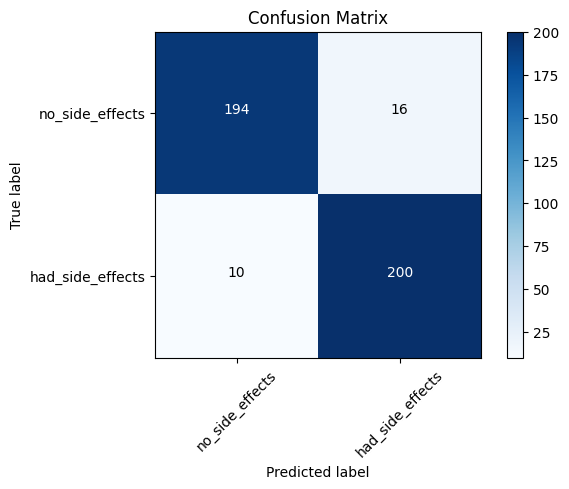

In [24]:
cm_plot_labels = ['no_side_effects','had_side_effects']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Saving and loading a Model

*   Using model.save()
*   Using model.to_json()

In [ ]:
# Using model.save()

# This method of saving will save everything about the model – the architecture, the weights, the optimizer,
# the state of the optimizer, the learning rate, the loss, etc.

model.save('models/medical_trial_model.keras')

from keras.models import load_model
new_model = load_model('models/medical_trial_model.keras')

new_model.summary()

# We can also inspect attributes about the model, like the optimizer and loss by calling model.optimizer
# and model.loss on the loaded model and compare the results to the previously saved model.

In [ ]:
# Using model.to_json()

# This will not save the model weights, configurations, optimizer, loss or anything else. This only saves
# the architecture of the model.

json_string = model.to_json()

from keras.models import model_from_json
model_architecture = model_from_json(json_string)

model_architecture.summary()

We can also use this same approach to saving and loading the model architecture to and from a YAML string. To do so, we use the functions to_yaml() and model_from_yaml() in the same fashion as we called the json functions.

In [ ]:
# Using model.save_weights()

# This function only saves the weights of the model.

model.save_weights('models/my_model_weights.keras')

# At a later point, we could then load the saved weights in to a new model, but the new model will
# need to have the same architecture as the old model before the weights can be saved.

model2 = Sequential([
    Dense(units=16, input_shape=(1,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

model2.load_weights('models/my_model_weights.keras')
model2.get_weights()